# Quantum Machine Learning

https://qiskit-community.github.io/qiskit-machine-learning/tutorials/index.html \
https://qiskit-community.github.io/qiskit-machine-learning/tutorials/02a_training_a_quantum_model_on_a_real_dataset.html

In [1]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import random
from qiskit.circuit.library import ZZFeatureMap
from qiskit.circuit.library import RealAmplitudes
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import StatevectorSampler
from matplotlib import pyplot as plt
from IPython.display import clear_output
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

In [2]:
iris_data = load_iris()
#print(iris_data.DESCR)

In [3]:
features = iris_data.data
#Normalization of features to [0,1]
features = MinMaxScaler().fit_transform(features)

labels = iris_data.target

In [4]:
df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
df["class"] = pd.Series(iris_data.target)

#sns.pairplot(df, hue="class", palette="tab10")

In [5]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


## Classical classifier:

In [6]:
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=123
)

svc = SVC()
svc.fit(train_features, train_labels)

SVC()

In [7]:
train_score = svc.score(train_features, train_labels)
test_score = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score:.2f}")
print(f"Classical SVC on the test dataset:     {test_score:.2f}")

Classical SVC on the training dataset: 0.99
Classical SVC on the test dataset:     0.97


## Quantum Classifier

### We need to construct feature map - which will store our classical data as gate parameters:

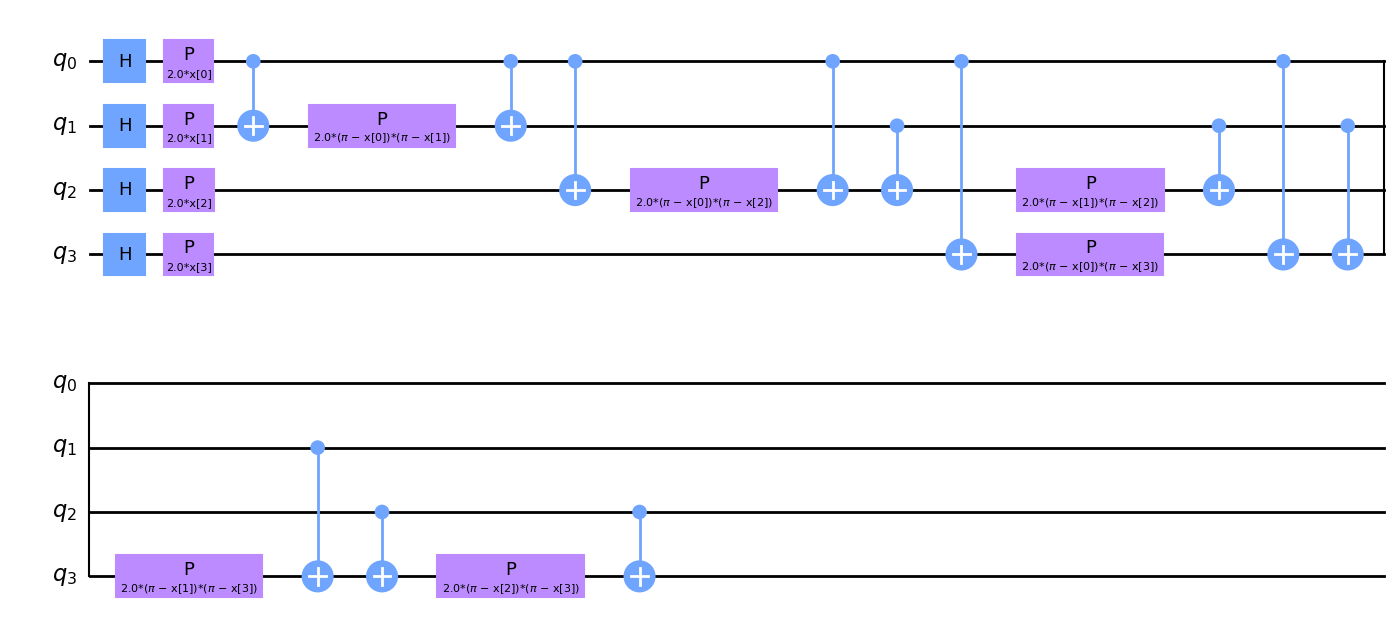

In [8]:
num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

### Now let's create the anzats - being our quantum neural network which we need to train:

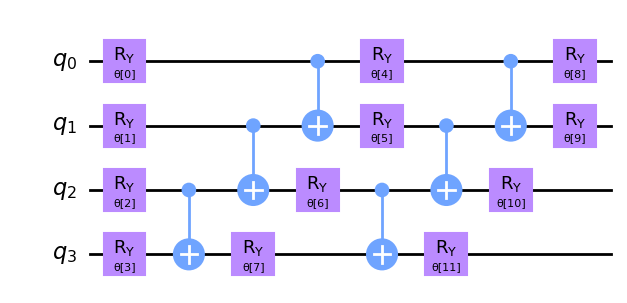

In [21]:
ansatz = RealAmplitudes(num_qubits=num_features, reps=2)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

In [10]:
optimizer = COBYLA(maxiter=100)

In [22]:
objective_func_vals = []

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    print('Iteration: ', len(objective_func_vals), 'Cost function: ', obj_func_eval)

In [23]:
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

Iteration:  100 Cost function:  1.2019188484354966
Training time: 62 seconds


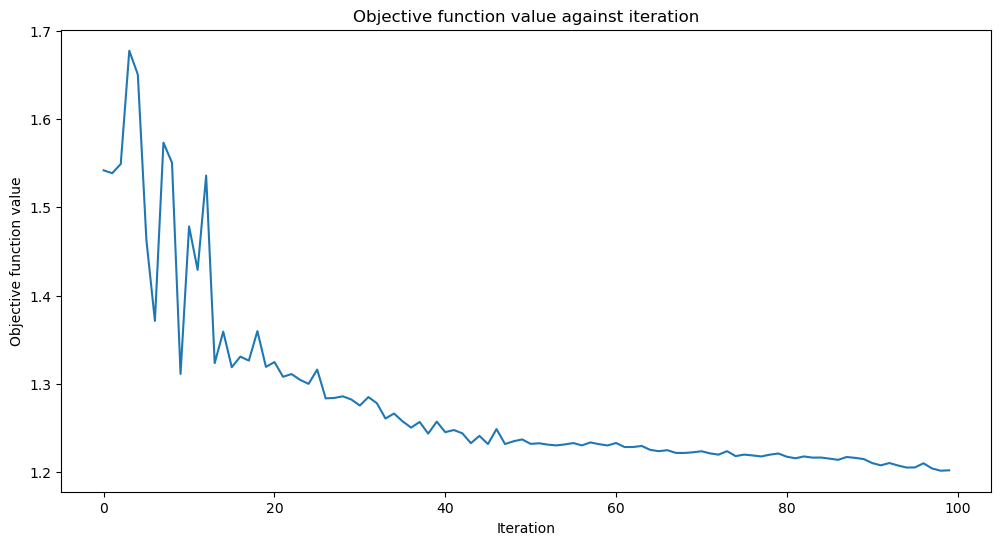

In [24]:
plt.rcParams["figure.figsize"] = (12, 6)
plt.title("Objective function value against iteration")
plt.xlabel("Iteration")
plt.ylabel("Objective function value")
plt.plot(range(len(objective_func_vals)), objective_func_vals)
plt.show()

In [25]:
train_score_vqc = vqc.score(train_features, train_labels)
test_score_vqc = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset: {train_score_vqc:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_vqc:.2f}")

Quantum VQC on the training dataset: 0.72
Quantum VQC on the test dataset:     0.77
